In [10]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

from vae.models.vae import VAE
from vae.trainers.trainer import ModelTrainer
#from trainers.trainer import ModelTrainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
torch.manual_seed(1)

bs= 128

train = datasets.MNIST(root='../data/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False)

test = datasets.MNIST(root='../data/',
                    train=False,
                    transform=transforms.ToTensor(),
                    download=False) 

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=bs, shuffle=False)

In [13]:
import numpy as np

class ModelTrainer(object):

    def __init__(self,
                 model,
                 train_loader,
                 test_loader,
                 optimizer='adam',
                 lr=1e-3,
                 batch_size=100,
                 n_epochs=15,
                 seed=1,
                 verbose=True):
        """
            The ModelTrainer module
            
            Inputs:
            -------
            model (model):
                - The model to train. It should contain a loss_fonction method taken as
                convergence criteria
            train_loader (DataLoader):
                - DataLoader containng the train dataset
            test_loader (DataLoader):
                - DataLoader containing the test dataset
            optimizer (str):
                - The optimizer's name
            lr (float):
                - The learning rate to use
            batch_size (int):
                - The batch_size for training
            n_epochs (int):
                - The number of epochs for training
            seed (int):
                - The random seed to use
            verbose (Bool):
                - Verbosity
        """

        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        random.seed(seed)
        np.random.seed(seed)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.n_epochs = n_epochs
        self.verbose = True

        if optimizer == 'adam':
            self.optimizer = optim.Adam(model.parameters(), lr=lr)

        else:
            raise Exception(f"Optimizer {optimizer} is not defined")

    def train(self):
        for epoch in range(self.n_epochs):
            self.__train_epoch(epoch)
            self.__test_epoch()

    def __train_epoch(self, epoch):
        self.model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(self.train_loader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            recon_batch, mu, log_var = self.model(data)
            loss = self.model.loss_function(recon_batch, data, mu, log_var)
    
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
    
            if batch_idx % 100 == 0 and self.verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.train_loader.dataset),
                    100. * batch_idx / len(self.train_loader), loss.item() / len(data)))
                
        if self.verbose:
            print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(self.train_loader.dataset)))
    

    def __test_epoch(self):
        self.model.eval()
        test_loss= 0
        with torch.no_grad():
            for data, _ in self.test_loader:
                data = data.to(self.device)
                recon, mu, log_var = self.model(data)
        
                # sum up batch loss
                test_loss += self.model.loss_function(recon, data, mu, log_var).item()

        test_loss /= len(self.test_loader.dataset)

        if self.verbose:
            print('====> Test set loss: {:.4f}'.format(test_loss))

In [14]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()

In [15]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [16]:
trainer = ModelTrainer(vae, train_loader, test_loader)
trainer.train()

Train Epoch: 0 [0/60000 (0%)]	Loss: 552.344604
Train Epoch: 0 [12800/60000 (21%)]	Loss: 187.776321
Train Epoch: 0 [25600/60000 (43%)]	Loss: 182.135422
Train Epoch: 0 [38400/60000 (64%)]	Loss: 176.360733
Train Epoch: 0 [51200/60000 (85%)]	Loss: 175.167053
====> Epoch: 0 Average loss: 189.8527
====> Test set loss: 169.8956
Train Epoch: 1 [0/60000 (0%)]	Loss: 171.591293
Train Epoch: 1 [12800/60000 (21%)]	Loss: 174.289261
Train Epoch: 1 [25600/60000 (43%)]	Loss: 162.901184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 161.025787
Train Epoch: 1 [51200/60000 (85%)]	Loss: 157.064270
====> Epoch: 1 Average loss: 167.4531
====> Test set loss: 163.9373
Train Epoch: 2 [0/60000 (0%)]	Loss: 168.132263
Train Epoch: 2 [12800/60000 (21%)]	Loss: 165.537109
Train Epoch: 2 [25600/60000 (43%)]	Loss: 167.621857
Train Epoch: 2 [38400/60000 (64%)]	Loss: 168.752167
Train Epoch: 2 [51200/60000 (85%)]	Loss: 164.822693
====> Epoch: 2 Average loss: 163.4267
====> Test set loss: 161.5803
Train Epoch: 3 [0/60000 (0%)]	L

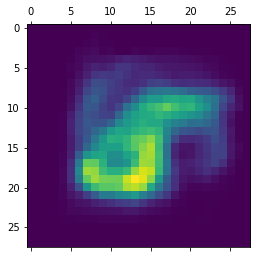

In [18]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decode(z)
    sample = torch.reshape(sample, (64, 28, 28))
plt.matshow(sample.cpu().numpy()[0])